In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90


np.random.seed(1)

get_px = lambda x: web.DataReader(x, 'google', start='2015-01-01', end='2017-01-01')['Close']

symbols = ['SPY','TLT','MSFT']
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
lrets = np.log(data/data.shift(1)).dropna()

In [2]:
from arch.unitroot import ADF
x = w = np.random.normal(size=1000)
for t in xrange(1000):
    x[t] = x[t-1] + w[t]
print(ADF(x, max_lags=10).summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.714
P-value                         0.424
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Stationary test

In [3]:
from arch.unitroot import ADF
print(ADF(data.SPY, max_lags=10).summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.132
P-value                         0.232
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


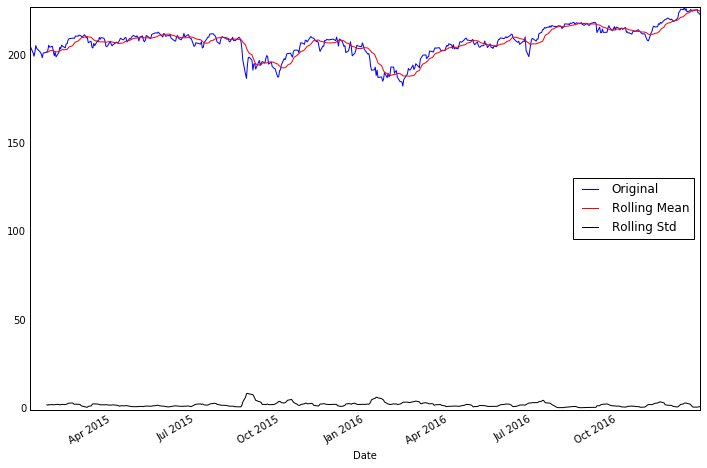

Results of Dickey-Fuller Test:
Test Statistic                  -2.132370
p-value                          0.231699
#Lags Used                       0.000000
Number of Observations Used    503.000000
Critical Value (5%)             -2.867303
Critical Value (1%)             -3.443418
Critical Value (10%)            -2.569840
dtype: float64
Test:
 do not reject H1: Time Series is un-stationary.
  stationary     10% xc  non-stationary
<------------------|---------x------>
('                 -2.57 ', '  -2.13')


In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    """
    var timeseries;
    calculate the moving avagage with respect to mean and standard deviation of time series respectively,
    and output the result of ADF test, and its visualisation
    """
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd =  timeseries.rolling(window=12,center=False).std()         
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    
    #orig = plt.plot(timeseries, color='blue',label='Original')
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title="Rolling Mean & Standard Deviation"
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
    ylimp=max(max(timeseries),1)
    ylimm=min(min(timeseries),-1)
    plt.ylim(ylimm,ylimp)
    #plt.axes(frameon = 0)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    critical=np.array([0.,0.,0.])
    i=0
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        critical[i]=value
        i=i+1
    print(dfoutput)
    # do test hypotheses
    test=sum(critical>dfoutput[0])
    if (test==3):
        print("Test:\n do not reject H0: Time Series is stationary, under 1% significant level.") 
        print("  stationary     1% xc   non-stationary")
        print("<-------x-----------|--------------->")
        print("      %5.2f       %5.2f " %(dfoutput[0] ,critical[0]))
    elif (test==2):
        print("Test:\n do not reject H0: Time Series is stationary, under 5% significant level.")  
        print("  stationary     1% xc   non-stationary")
        print("<------------------|---------x------>")
        print("                 %5.2f " %critical[0], "  %5.2f" % dfoutput[0])
    elif(test==1):
        print("  stationary     5% xc   non-stationary")
        print("<------------------|---------x------>")
        print("                 %5.2f " %critical[1], "  %5.2f" % dfoutput[0])
        print("Test:\n do not reject H0: Time Series is stationary, under 10% significant level.") 
    else:
        print("Test:\n do not reject H1: Time Series is un-stationary.") 
        print("  stationary     10% xc  non-stationary")
        print("<------------------|---------x------>")
        print("                 %5.2f " %critical[2], "  %5.2f" % dfoutput[0])
        
test_stationarity(data.SPY)

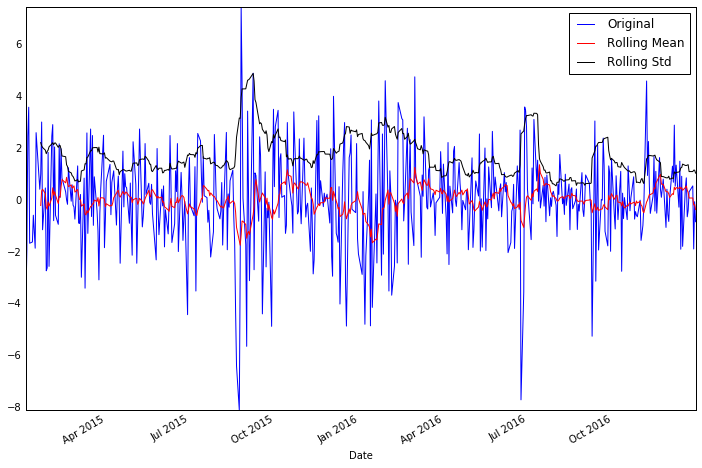

Results of Dickey-Fuller Test:
Test Statistic                 -22.629760
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    502.000000
Critical Value (5%)             -2.867315
Critical Value (1%)             -3.443444
Critical Value (10%)            -2.569846
dtype: float64
Test:
 do not reject H0: Time Series is stationary, under 1% significant level.
  stationary     1% xc   non-stationary
<-------x-----------|--------------->
      -22.63       -2.87 


In [5]:
spy_diff = data.SPY - data.SPY.shift(1)  
test_stationarity(spy_diff.dropna(inplace=False))

## random white noise test

   Augmented Dickey-Fuller Results   
Test Statistic                -31.176
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
('Ljung-Box value = ', 0.99407681534210046)


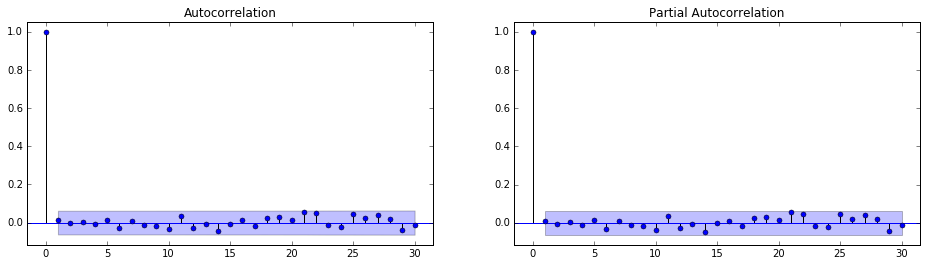

In [6]:
from statsmodels.tsa import stattools 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

x = np.random.normal(size=1000)
print(ADF(x, max_lags=10).summary())
LjungBox=stattools.q_stat(stattools.acf(x)[1:6], len(x))
print("Ljung-Box value = ",LjungBox[1][-1])

plt.figure(figsize=(16,4))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
plot1=plot_acf(x, lags=30, ax=ax1)
plot2=plot_pacf(x,lags=30, ax=ax2)

## ARCH Modeling

Iteration:      5,   Func. Count:     36,   Neg. LLF: 2863.23265466
Iteration:     10,   Func. Count:     69,   Neg. LLF: 2818.8441946
Iteration:     15,   Func. Count:     99,   Neg. LLF: 2816.926378
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2816.92632834
            Iterations: 16
            Function evaluations: 105
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.042
Mean Model:             Constant Mean   Adj. R-squared:                 -0.042
Vol Model:                      GARCH   Log-Likelihood:               -2816.93
Distribution:                  Normal   AIC:                           5641.85
Method:            Maximum Likelihood   BIC:                           5661.48
                                        No. Observations:                 1000
Date:                Sun, Jul 09 2017  

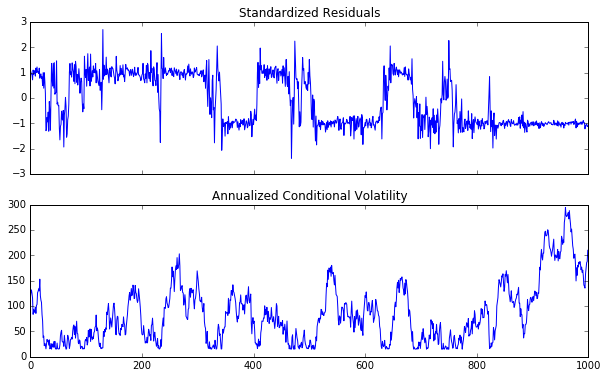

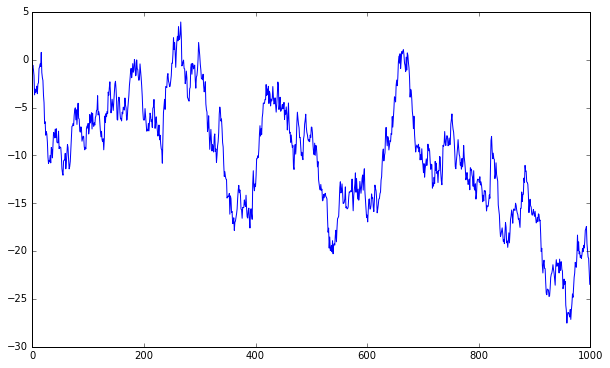

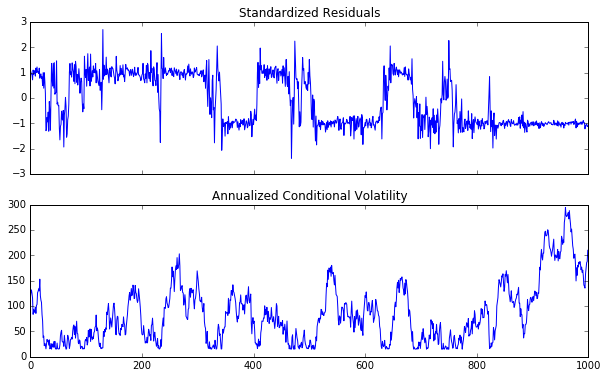

In [7]:
from arch import arch_model

x = w = np.random.normal(size=1000)
for t in xrange(1000):
    x[t] = x[t-1] + w[t]

am = arch_model(x) 
res = am.fit(update_freq=5)
print(res.summary())
plt.plot(x)
res.plot(annualize='D')

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1516.85368814
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1486.41418982
Iteration:     15,   Func. Count:     97,   Neg. LLF: 1484.82969799
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1484.8296729
            Iterations: 16
            Function evaluations: 103
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                      -0.040
Mean Model:             Constant Mean   Adj. R-squared:                 -0.040
Vol Model:                      GARCH   Log-Likelihood:               -1484.83
Distribution:                  Normal   AIC:                           2977.66
Method:            Maximum Likelihood   BIC:                           2994.55
                                        No. Observations:                  504
Date:                Sun, Jul 09 2017

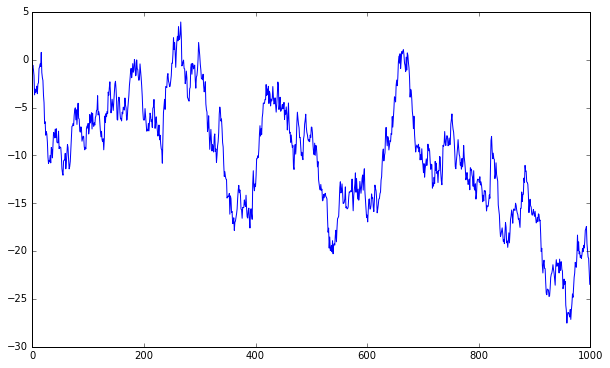

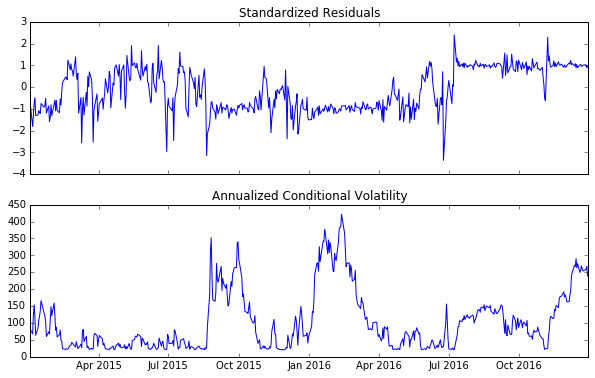

In [8]:
am = arch_model(data.SPY) 
res = am.fit(update_freq=5)
print(res.summary())
plt.plot(x)
res.plot(annualize='D')
plt.show()

## facebook prohpet : forecasting in scale

In [9]:
from fbprophet import Prophet

df_spy = data.SPY.copy().to_frame('y')
df_spy['ds'] = pd.to_datetime(df_spy.index)

prophet = Prophet()
prophet.fit(df_spy)
future = prophet.make_future_dataframe(periods=100)
display(df_spy.tail())
forecast = prophet.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(10))

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,y,ds
Date,,
2016-12-23,225.71,2016-12-23
2016-12-27,226.27,2016-12-27
2016-12-28,224.40,2016-12-28
2016-12-29,224.35,2016-12-29
2016-12-30,223.53,2016-12-30


,ds,yhat,yhat_lower,yhat_upper
594,2017-03-31,226.238497,214.279719,237.182505
595,2017-04-01,227.491861,215.407771,238.116271
596,2017-04-02,227.543145,214.878029,239.975967
597,2017-04-03,226.471444,214.038133,237.715099
598,2017-04-04,226.432510,214.318039,238.416849
599,2017-04-05,226.684951,213.322347,238.835923
600,2017-04-06,226.847897,214.389793,239.130672
601,2017-04-07,226.597484,213.803707,239.524805
602,2017-04-08,227.850849,214.662088,240.512509
603,2017-04-09,227.902132,214.881285,240.477136


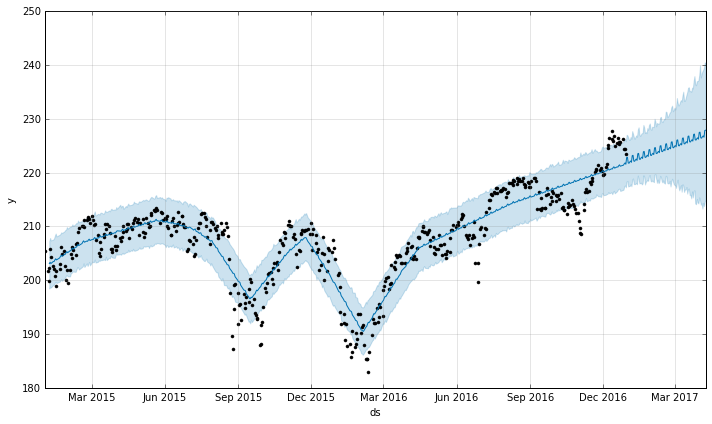

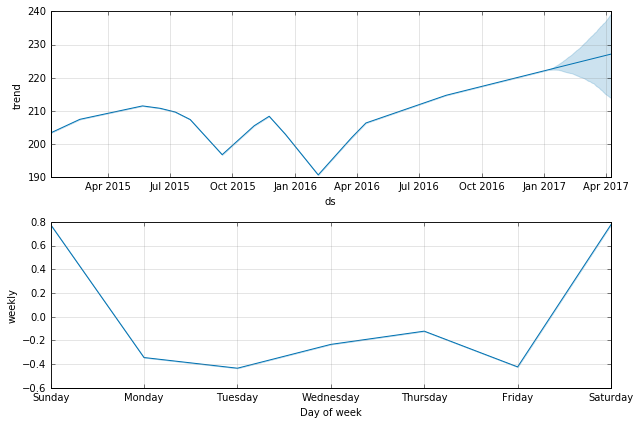

In [10]:
prophet.plot(forecast[3:])
plt.show()
prophet.plot_components(forecast[3:])
plt.show()

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


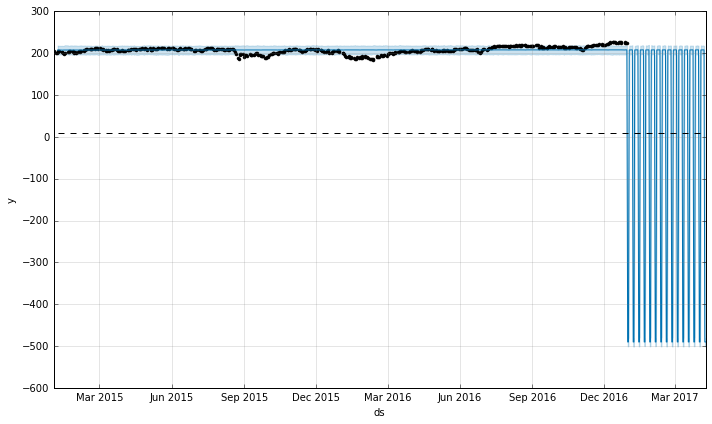

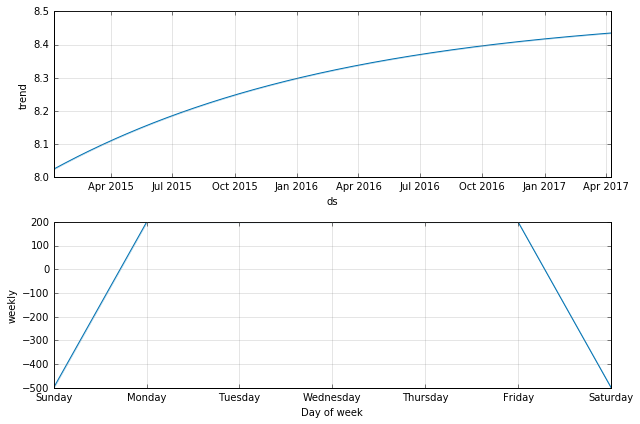

In [17]:
prophet_log = Prophet(growth='logistic')
prophet_log.fit(df_spy)
future_log = prophet_log.make_future_dataframe(periods=100)
future_log['cap'] = 8.5
forecast = prophet_log.predict(future_log)
prophet_log.plot(forecast[3:])
plt.show()
prophet_log.plot_components(forecast[3:])
plt.show()

## detect changepoints

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


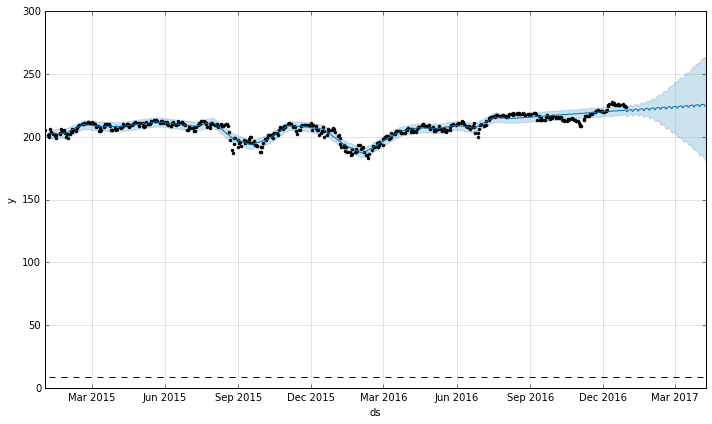

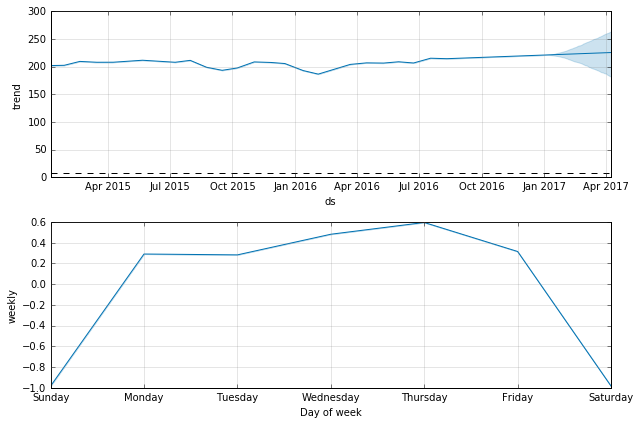

In [19]:
prophet_cp = Prophet(changepoint_prior_scale=0.5)
prophet_cp.fit(df_spy)
future_cp = prophet_cp.make_future_dataframe(periods=100)
future_cp['cap'] = 8.5
forecast = prophet_cp.predict(future_cp)
prophet_log.plot(forecast[3:])
plt.show()
prophet_cp.plot_components(forecast[3:])
plt.show()